# RRTMG on Keeling 

In today's class, we will use this notebook to work on Atmospheric Science application problems with the RRTMG model. We'll break the class down into three main parts: 
1. Calculate RRTMG under Clear Sky Conditions (simulated/observed humidity profile)
2. Calculate RRTMG under All Sky Conditions (simulated/observed humidity profile)
3. How clouds are represented in RRTMG 


By the end of the class, you will know: 
1. What are the minimum input you need to load into the RRTMG model;
2. What the output of the RRTMG model would look like and the calculations you can do with the output

# Part I: Calculating Radiative Fluxes and Heating Rates in **Clear Sky Conditions**

RRTMG is one of the packages installed in a global climate model, where the domain (surface area) they cover include the entire Earth. For the first part in class, we'll look at how the heating rates and radiative fluxes would look like if we loaded different input into the model. 

To do so, we will be looking at **simulated humidity profiles** from the Community Earth System Model (CESM) version and **observed data** collected from [radiosonde data by the University of Wyoming](https://weather.uwyo.edu/upperair/sounding.html). We'll look at San Deigo, CA, for its proximity to the eastern Pacific stratocumulus deck. 

## Working with CESM Simulations and Observational Data in the RRTMG Model 

Climate models describes the various earth system processes by comprising of multiple components, including the atmospehric component, land, ocean, sea ice etc.. In the case of CESM model, the atmosphere is ran in the Community Atmosphere Model (CAM), where the latest version is version 6, and commonly known as CAM6 in CESM version 2. This component is also where the RRTMG model resides in. However, the output we'll be looking at is ran on CESM-1 CAM5, which is an older version, but the differences between the climate models are outside the scope of this tutorial, and the RRTMG model has no difference between the two CESM versions ([Danabasoglu et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS001916)).

To get the RRTMG model running in Climlab, we will need to let the model know what the initial conditions of the atmosphere we want to simulate be like - mainly the **temperature** and **water vapor profiles**. 
1. **Temperature:** Climlab has [`climlab.column_state()`](https://climlab.readthedocs.io/en/latest/api/climlab.domain.initial.html), which is a convenient routine that set the temperature profile by getting the arguments of the pressure levels (i.e. height axis). For CESM1 models, they are ran on a vertical profile of 26 atmospheric layers in all locations. 
2. **Water Vapor**: We will be loading the humidity profile from a fully coupled* model run on CESM-1 CAM5. 

#### <u>On the side: More about the dataset that we are looking at</u>
**1. What does coupled mean?**
   
All Earth processes interact with each other: for example, winds in the atmosphere may advect sea surface temperatures, which is an example of the atmosphere communicating with the ocean. With the multiple components in a climate model, the components communicate with each other through a coupler, a software that controls the execution and time evolution of systems (tehcnical details can be found [here](https://www.cesm.ucar.edu/models/cpl)). When all components are allowed to run based on their model dynamics, and then communicate with each other before moving on to the next step in time, this is what we called as fully coupled. However, it is not required that all components to be active in a single run. For example, the ocean and sea ice components can be turned off, and the atmosphere takes known data that is loaded by the user (e.g. observational records of sea surface temperatures like measurements from [Argo floats](https://argo.ucsd.edu/about/status/)) to conduct calculations and return output. This practice is commonly called as prescribed SSTs, and the simulations are referred as Atmosphere-only model runs. It is beneficial as it is computationally cheaper than a fully coupled model, and the field has a standard experiment known as the Atmospheric Model Intercomparison project (AMIP) so as to investigate model diagnosis, validation and data acess etc.. 

In the dataset that we are looking at, we are looking at a fully coupled simulation. 

#### Step 0. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
#import matplotlib.offsetbox as offsetbox
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
from __future__ import division, print_function, absolute_import
#from climlab import constants as const
#from climlab.radiation.radiation import _Radiation_SW
#from climlab.radiation.rrtm.utils import _prepare_general_arguments
#from climlab.radiation.rrtm.utils import _climlab_to_rrtm, _climlab_to_rrtm_sfc, _rrtm_to_climlab
from inclass_func_full import *


warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

/data/keeling/a/rytam2/miniconda3/envs/rrtmg/lib/python3.11/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


### Step 1. Loading Humidity Profile

What we will load here are both the simulated data from the fully coupled CESM model run, and the observed radiosonde data collected at a weather station in San Diego (Nov 10, 00Z). 

In [2]:
cesm_Q = xr.open_dataarray('../Data/cesm_Q.nc') # model data 
q_obs = xr.open_dataset('../Data/sd_q_sortedorder.nc') # obs data

cesm_Q.lev #EDIT THIS to check out the two different sets of data 

<xarray.DataArray 'lev' (lev: 26)>
array([  3.544638,   7.388814,  13.967214,  23.944625,  37.23029 ,  53.114605,
        70.05915 ,  85.439115, 100.514695, 118.250335, 139.115395, 163.66207 ,
       192.539935, 226.513265, 266.481155, 313.501265, 368.81798 , 433.895225,
       510.455255, 600.5242  , 696.79629 , 787.70206 , 867.16076 , 929.648875,
       970.55483 , 992.5561  ])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
    time     object ...
    lat      float64 ...
    lon      float64 ...
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

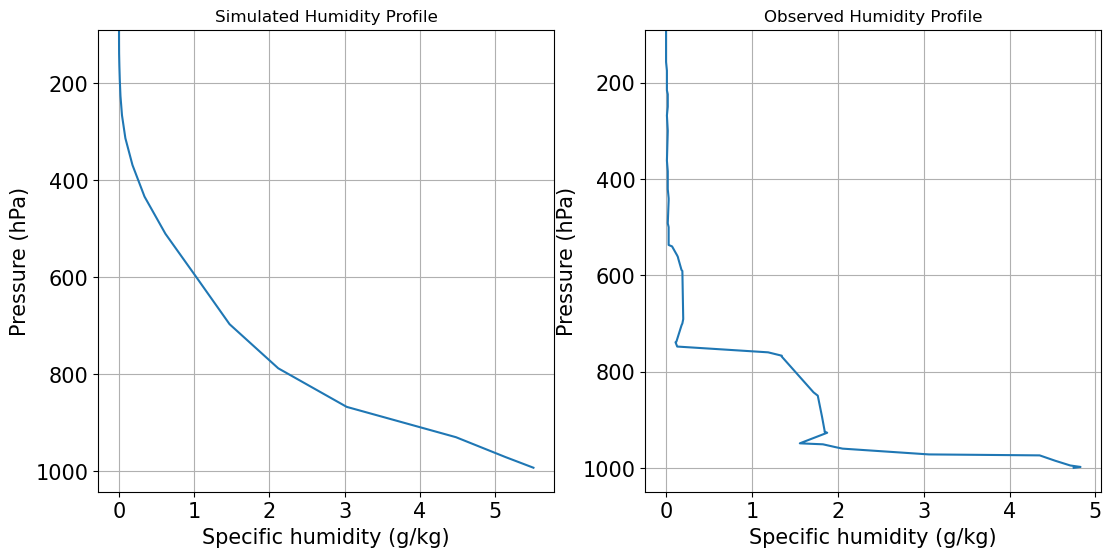

In [3]:
plot_humidity(cesm_Q*1000., cesm_Q.lev, q_obs.q, q_obs.lev) 

### Step 2: Calculate the respective radiative fluxes and heating rates

#### Simulation 

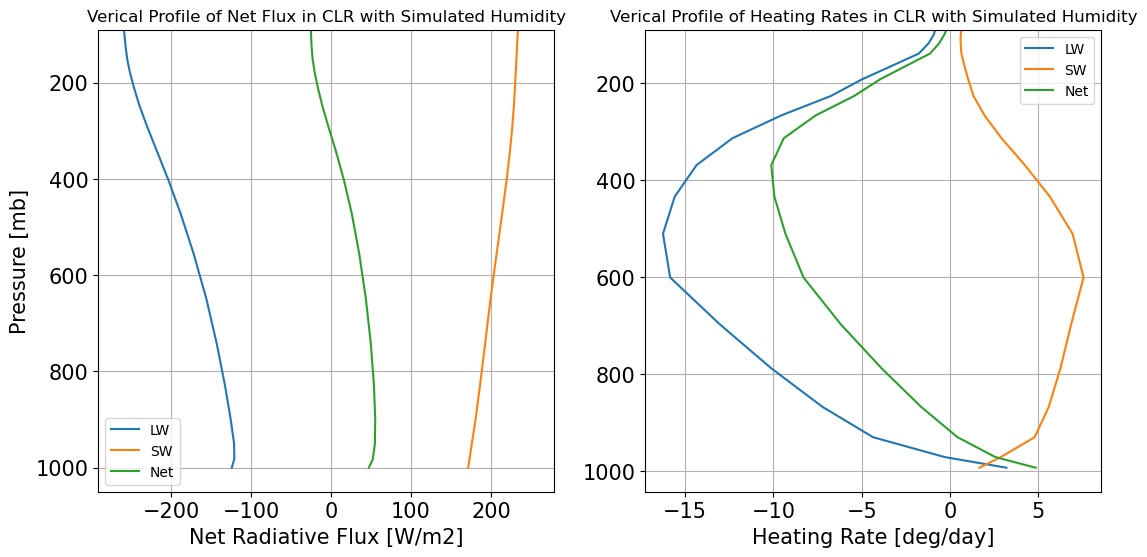

In [4]:
# Now we check out what the vertical profile of the net radiative fluxes and heating rate under this water vapor profile would look like 
# First we do the calculations
rad_LW_cesm_clr, rad_SW_cesm_clr = model_setup(cesm_Q.values, cesm_Q.lev)

# and now we PLOT
filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/simulated_clr.png'
plotting_sec1(rad_LW_cesm_clr, rad_SW_cesm_clr,'CLR','Simulated',filepath)

#### Observations

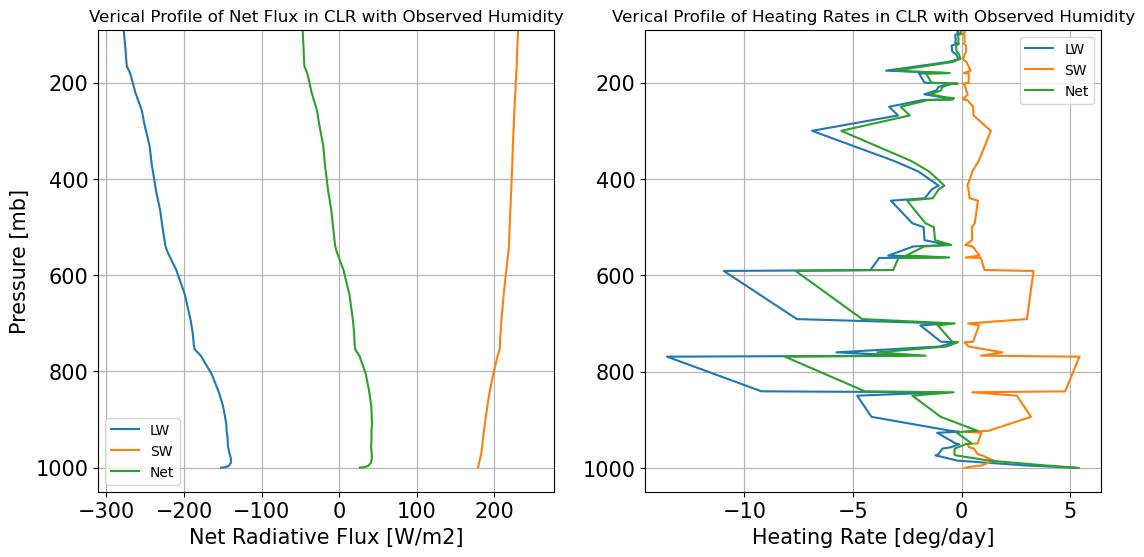

In [5]:
rad_sd_cesm_LW_clr, rad_sd_cesm_SW_clr = model_setup(q_obs.q.values/1000, q_obs.lev.values)
filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/observed_clr.png'
plotting_sec1(rad_sd_cesm_LW_clr, rad_sd_cesm_SW_clr,'CLR','Observed',filepath)

# Part II: Calculating Heating Rates and Radiative Fluxes in **All Sky Conditions**

Check out the same location with a cloud added. 

#### Simulated Humidity Profile

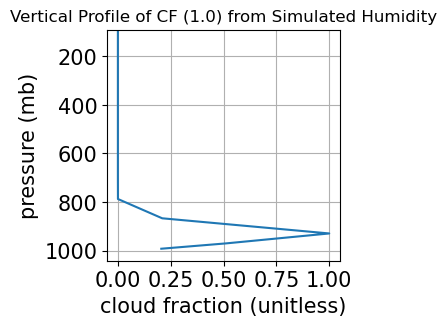

In [6]:
mystate_sim = climlab.column_state(lev=cesm_Q.lev)
lev = cesm_Q.lev
cldfrac = 1.0 # layer cloud fraction
r_liq = 10.  # Cloud water drop effective radius (microns)
clwp = 40  # in-cloud liquid water path (g/m2)

cldfrac_sim_full = (cldfrac*np.exp(-(lev-lev[-3])**2/(2*25.)**2)).values  #Add cloud at local maximum of observed humidity profile 
mycloud_sim_full = {'cldfrac': cldfrac_sim_full,
            'clwp': np.zeros_like(mystate_sim.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate_sim.Tatm) + r_liq,
            }

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/CF_simulated_humidity.png'
cf_plot(cldfrac_sim_full,lev,'CF'+' ('+str(cldfrac)+') '+'from Simulated Humidity',filepath)

At its peak, the cloud fraction is 100%. 

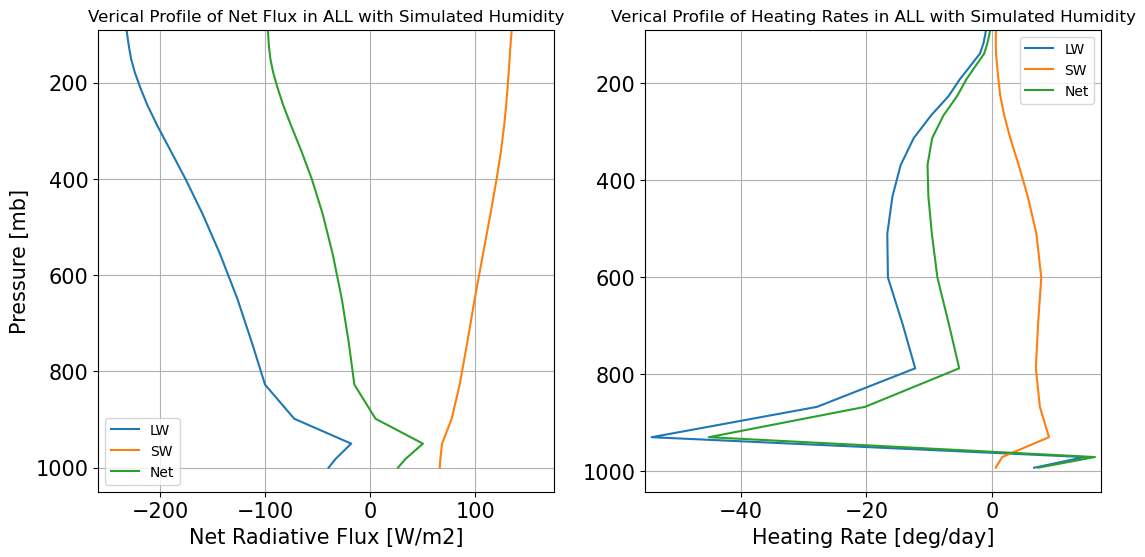

In [7]:
ICLD = 1
nmcica = 100
radmodel_sw_sim_locmax,radmodel_lw_sim_locmax,p_lev,dz = initmodels(ICLD,mystate_sim,cesm_Q,mycloud_sim_full)
step_model(radmodel_sw_sim_locmax,radmodel_lw_sim_locmax,nmcica)
filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/simulated_all.png'
plotting_sec1(radmodel_lw_sim_locmax, radmodel_sw_sim_locmax,'ALL','Simulated',filepath)

#### Observed Humidity Profile

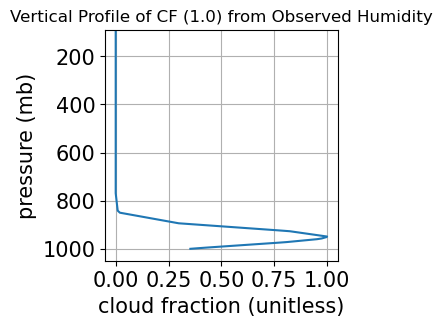

In [8]:
mystate_obs = climlab.column_state(lev=q_obs.lev)
lev = q_obs.lev
cldfrac = 1.0# layer cloud fraction
r_liq = 10.  # Cloud water drop effective radius (microns)
cldfrac_obs_full = (cldfrac*np.exp(-(lev-lev[-10])**2/(2*25.)**2)).values
mycloud_obs_full = {'cldfrac': cldfrac_obs_full,
            'clwp': np.zeros_like(mystate_obs.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate_obs.Tatm) + r_liq,
            }

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/CF_observed_humidity.png'
cf_plot(cldfrac_obs_full,lev,'CF'+' ('+str(cldfrac)+') '+'from Observed Humidity',filepath)

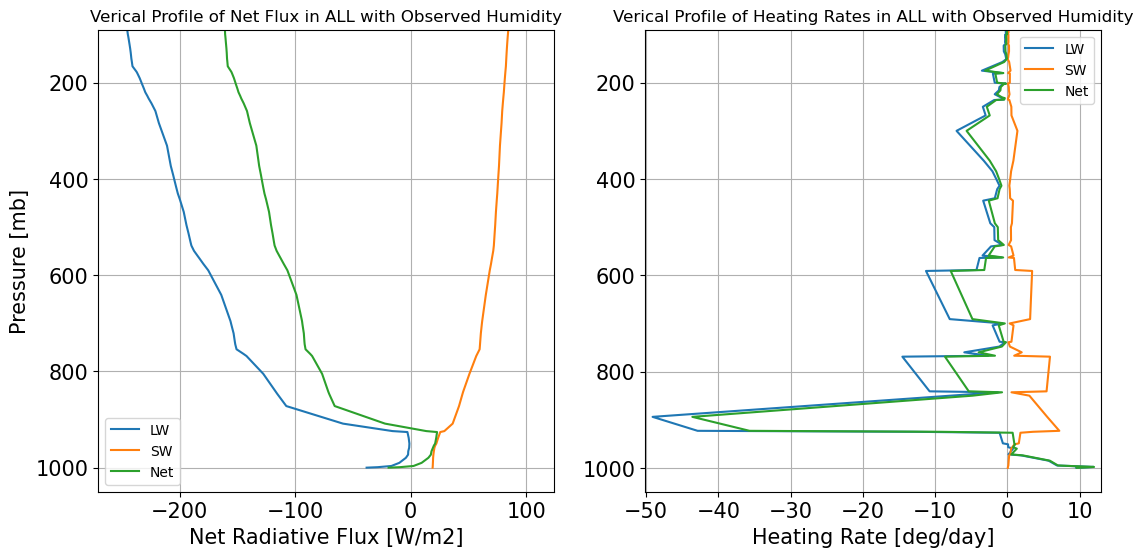

In [9]:
ICLD = 1
nmcica = 1
radmodel_sw_obs_locmax,radmodel_lw_obs_locmax,p_lev,dz = initmodels(ICLD,mystate_obs,q_obs.q/1000,mycloud_obs_full)
step_model(radmodel_sw_obs_locmax,radmodel_lw_obs_locmax,nmcica)
filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/observed_all.png'
plotting_sec1(radmodel_lw_obs_locmax, radmodel_sw_obs_locmax,'ALL','Observed',filepath)

# Part III: Cloud Properties Representations 

### Model Schemes on Cloud Representation: Cloud Overlap

Remember the infinite combination of how cloud can be organized within a grid cell? McICA comes into play! 

#### Investigate the different Cloud Overlap Schemes (1-4 and case 0, i.e. clear sky)

We'll continue with the partially cloudy condition defined as follow, but change the distribution of the cloud to a idealized Gaussian bump centered at level i. 

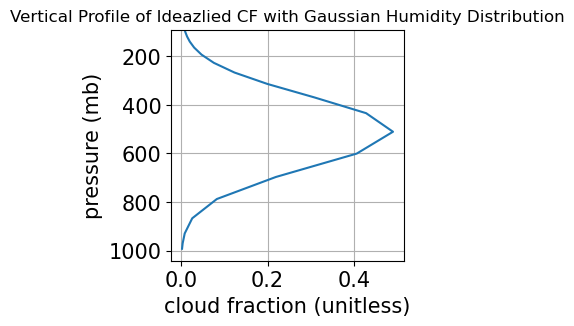

In [10]:
mystate = climlab.column_state(lev=cesm_Q.lev)
lev = cesm_Q.lev
cldfrac = 0.5 # layer cloud fraction
r_liq = 10.  # Cloud water drop effective radius (microns)
clwp = 40  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 18
cldfrac_mcica = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2)))**0.03 * cldfrac
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac_mcica,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/CF_idealized_gaussian.png'
cf_plot(cldfrac_mcica,lev,'Ideazlied CF with Gaussian Humidity Distribution',filepath)

#### A. Clear-sky

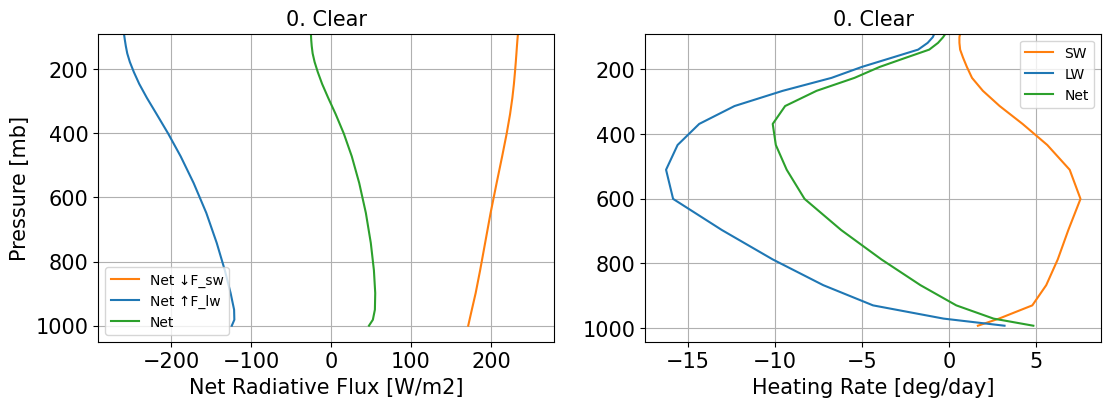

In [11]:
# experiment with different overlap method and nmicia
icld = 0 # no cloud
nmcica = 1 # no need to do multiple mcica since no cloud

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/overlap_clr.png'
plotting_sec3(radmodel_lw, radmodel_sw,filepath)

#### B. Random

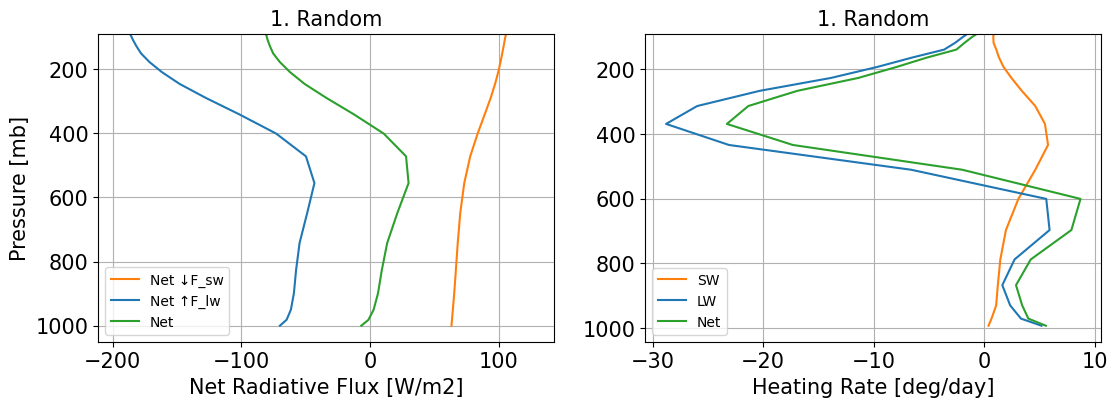

In [12]:
# experiment with different overlap method and nmicia
icld = 1
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/overlap_random.png'
plotting_sec3(radmodel_lw, radmodel_sw,filepath)

#### C. Random-maximum

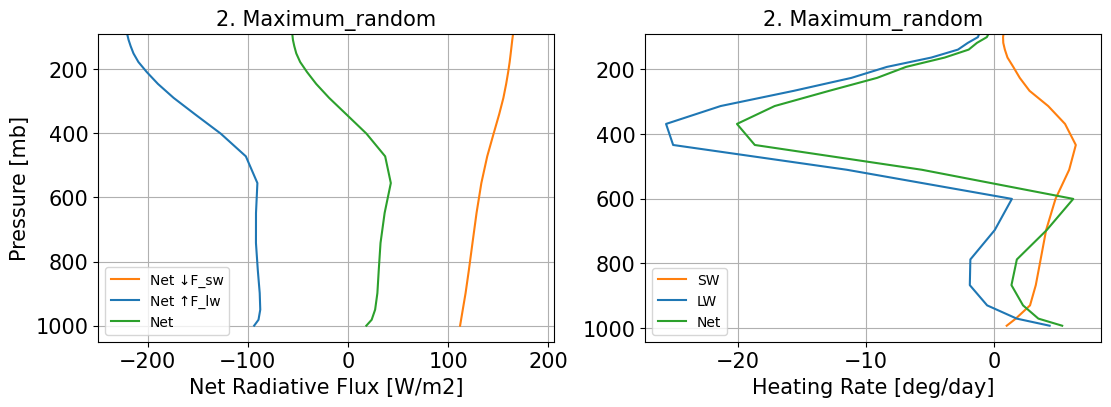

In [13]:
icld = 2
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/overlap_maxrandom.png'
plotting_sec3(radmodel_lw, radmodel_sw,filepath)

#### D. Maximum

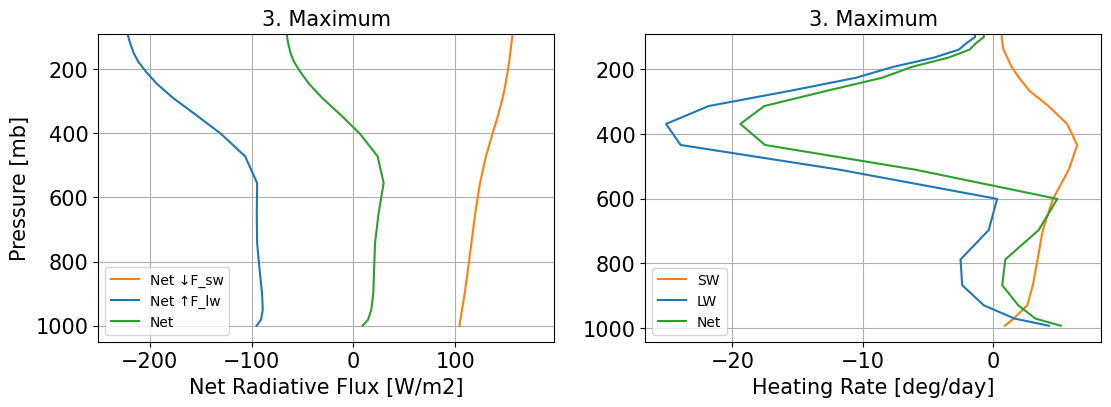

In [14]:
icld = 3
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/overlap_maximum.png'
plotting_sec3(radmodel_lw, radmodel_sw,filepath)

#### E. Exponential

In [15]:
icld = 4
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

filepath = '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/overlap_exponential.png'
plotting_sec3(radmodel_lw, radmodel_sw,filepath])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (1348808397.py, line 8)